# Drought Analysis in Sri Lanka

This notebook guides you through:

1. Fetching adm boundaries.
2. Fetching timeseries climate data (SPI).
3. Identifying the number of extreme drought days.
4. Plotting and mapping the results.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/worldbank/DECAT_Space2Stats/blob/main/docs/user-docs/space2stats_api_demo_spi_droughts.ipynb)

In [1]:
# !pip install space2stats-client folium mapclassify matplotlib plotnine

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from space2stats_client import Space2StatsClient
from shapely.geometry import shape
import json
from plotnine import (
    ggplot,
    aes,
    geom_map,
    coord_fixed,
    facet_wrap,
    scale_fill_distiller,
    element_rect,
    theme_void,
    theme,
)

## Fetch ADM Boundaries

Retrieved 25 ADM2 regions


Text(0.5, 1.0, 'Sri Lanka ADM2 Regions')

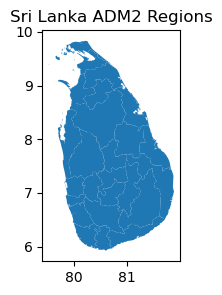

In [3]:
# Set up the client and fetch ADM2 boundaries for Sri Lanka
client = Space2StatsClient() # if locally, use base_url='http://localhost:8000'
ISO3 = "LKA"  # Sri Lanka 
ADM = "ADM2"
adm2_boundaries = client.fetch_admin_boundaries(ISO3, ADM)

print(f"Retrieved {len(adm2_boundaries)} ADM2 regions")
adm2_boundaries.plot(figsize=(3, 3))
plt.title("Sri Lanka ADM2 Regions")


## Fetch SPI Timeseries Data

In [9]:
# Define the fields and parameters
fields = ["spi"]
all_adm2_data = []

# Loop through each ADM2 region to fetch its data
for idx, adm2_feature in adm2_boundaries.iterrows():
    try:
        feature_gdf = gpd.GeoDataFrame([adm2_feature], geometry='geometry')

        result_df = client.get_timeseries(
            gdf=feature_gdf,
            spatial_join_method="centroid",
            fields=fields,
            start_date="2019-01-01",
            geometry= "polygon"
        )

        if not result_df.empty:
            region_name = adm2_feature['NAM_2']
            result_df['region'] = region_name
            all_adm2_data.append(result_df)
            print(f"Retrieved data for {region_name}")
        else:
            print(f"No data found for {adm2_feature['NAM_2']}")
    except Exception as e:
        print(f"Error retrieving data for region: {str(e)}")

# Combine all the dataframes
if all_adm2_data:
    all_adm2_data = pd.concat(all_adm2_data, ignore_index=True)
    print(f"Total records: {len(all_adm2_data)}")
else:
    print("No data was retrieved")

Fetching data for boundary 1 of 1...
Retrieved data for Kandy
Fetching data for boundary 1 of 1...
Retrieved data for Matale
Fetching data for boundary 1 of 1...
Retrieved data for Nuwara eliya
Fetching data for boundary 1 of 1...
Retrieved data for Ampara
Fetching data for boundary 1 of 1...
Retrieved data for Batticaloa
Fetching data for boundary 1 of 1...
Retrieved data for Trincomalee
Fetching data for boundary 1 of 1...
Retrieved data for Anuradhapura
Fetching data for boundary 1 of 1...
Retrieved data for Polonnaruwa
Fetching data for boundary 1 of 1...
Retrieved data for Kurunegala
Fetching data for boundary 1 of 1...
Retrieved data for Puttalam
Fetching data for boundary 1 of 1...
Retrieved data for Jaffna
Fetching data for boundary 1 of 1...
Retrieved data for Kilinochchi
Fetching data for boundary 1 of 1...
Retrieved data for Mannar
Fetching data for boundary 1 of 1...
Retrieved data for Mullaitivu
Fetching data for boundary 1 of 1...
Retrieved data for Vavuniya
Fetching data

## Map Monthly Hex Data (2024)

In [10]:
# Convert response data to a pandas dataframe
df = pd.DataFrame(all_adm2_data)

# Convert date strings to datetime objects
if 'date' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['date']):
    df['date'] = pd.to_datetime(df['date'])

df['year'] = df['date'].dt.year
df.head(2)

FID ISO_A3 ISO_A2 WB_A3 WB_REGION     WB_STATUS      NAM_0    NAM_1  \
0  8209    LKA     LK   LKA       SAR  Member State  Sri Lanka  Central   
1  8209    LKA     LK   LKA       SAR  Member State  Sri Lanka  Central   

  ADM1CD_c GEOM_SRCE  ...                              GlobalID Shape__Area  \
0   LKA001   UN SALB  ...  4636f0f5-8753-4e1c-8e75-a0bdf666a38c    0.157801   
1   LKA001   UN SALB  ...  4636f0f5-8753-4e1c-8e75-a0bdf666a38c    0.157801   

  Shape__Length           hex_id                      date       spi  \
0      2.961513  866102607ffffff 2019-01-01 00:00:00+00:00  0.427178   
1      2.961513  866102607ffffff 2019-02-01 00:00:00+00:00 -0.007487   

                                            geometry  area_id region  year  
0  {"type":"Polygon","coordinates":[[[80.58982915...        0  Kandy  2019  
1  {"type":"Polygon","coordinates":[[[80.58982915...        0  Kandy  2019  

[2 rows x 22 columns]

In [11]:
# Filter year and convert geometry to shapely objects
df_filter = df.loc[df['year'] == 2024].copy()
if isinstance(df_filter["geometry"].iloc[0], str):
    df_filter["geometry"] = df_filter["geometry"].apply(json.loads)
df_filter["geometry"] = df_filter["geometry"].apply(shape)
gdf = gpd.GeoDataFrame(df_filter, geometry="geometry", crs="EPSG:4326")
gdf['ym'] = gdf['date'].dt.strftime('%Y-%m')

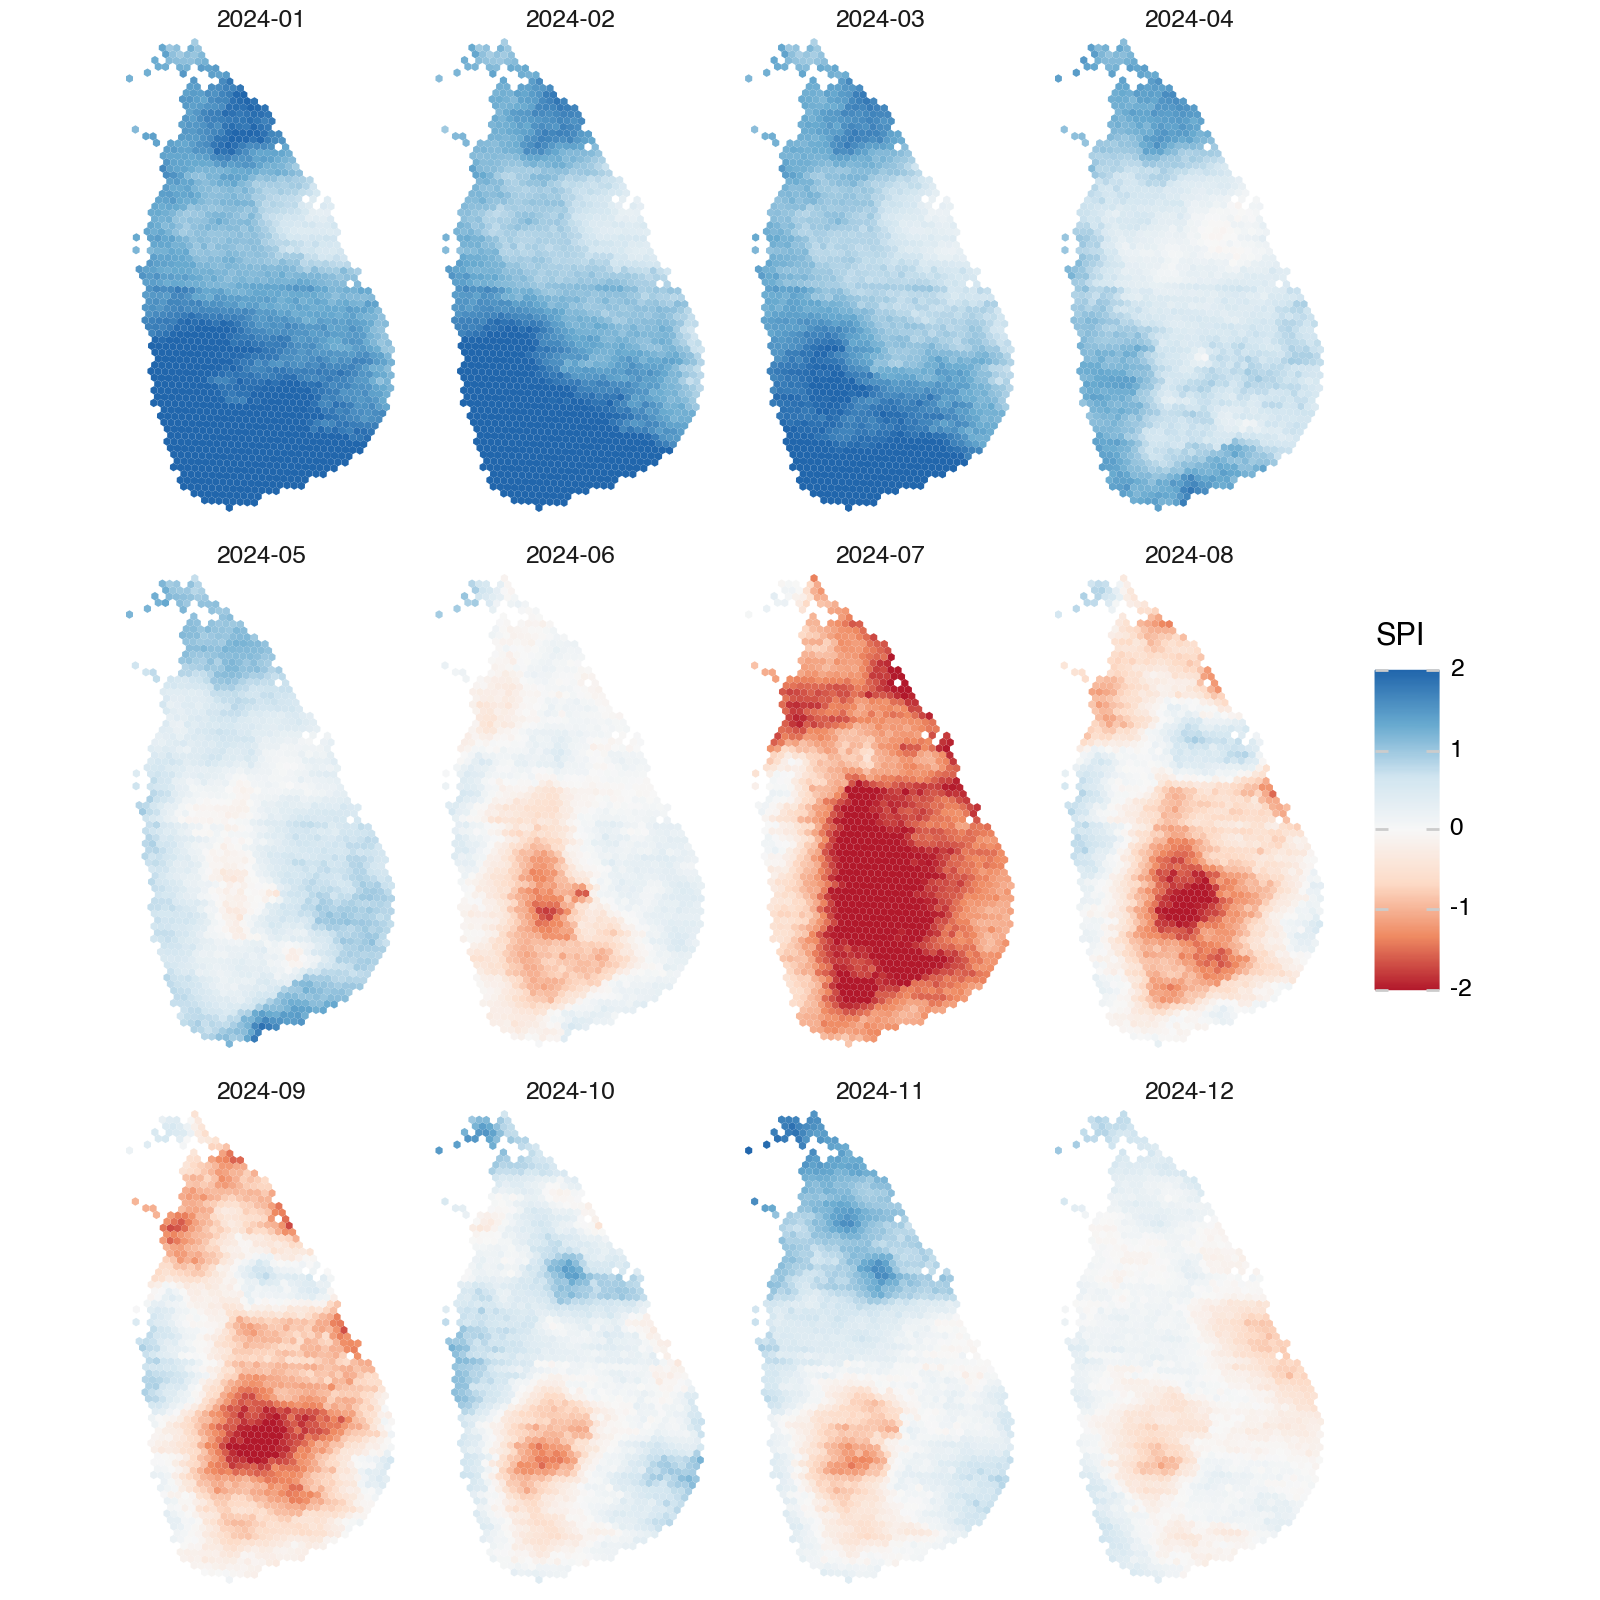

In [12]:
(
    ggplot(gdf)
    + geom_map(aes(fill="spi"), size=0)
    + scale_fill_distiller(type="div", palette="RdBu", name="SPI", limits=(-2, 2))
    + facet_wrap(
        "ym",
        ncol=4,
    )
    + coord_fixed(expand=False)
    + theme_void()
    + theme(
        figure_size=(8, 8),
        plot_margin=0.01,
        plot_background=element_rect(fill="white"),
        panel_spacing=0.025
    )
)

## Extract Extreme Drought Events per Year

In [13]:
# Convert response data to a pandas dataframe
gdf = all_adm2_data.copy()

# Convert date strings to datetime objects
if 'date' in gdf.columns and not pd.api.types.is_datetime64_any_dtype(gdf['date']):
    gdf['date'] = pd.to_datetime(gdf['date'])

gdf['year'] = gdf['date'].dt.year

# Set an extereme drought threshold
drought_threshold = -2

# Create a binary column indicating extreme drought days
gdf['extreme_drought'] = (gdf['spi'] <= drought_threshold).astype(int)

# Group by region and year, then count extreme drought days
yearly_drought = gdf.groupby(['region', 'year'])['extreme_drought'].sum().reset_index()

# Pivot the table to have years as columns
drought_pivot = yearly_drought.pivot(index='region', columns='year', values='extreme_drought')

# Rename columns for clarity
drought_pivot.columns = [f'{year}' for year in drought_pivot.columns]

# Add total drought days column
drought_pivot['Total Drought Days'] = drought_pivot.sum(axis=1)

# Sort by total drought days in descending order
drought_pivot = drought_pivot.sort_values('Total Drought Days', ascending=False)

# Reset index to make 'region' a regular column
result_table = drought_pivot.reset_index().rename(columns={'region': 'District'})

# Display the resulting table
display(result_table)


District  2019  2020  2021  2022  2023  2024  Total Drought Days
0   Nuwara eliya     0     0     0     0     0    78                  78
1          Kandy     0     0     0     0     0    69                  69
2        Badulla     0     0     0     0     0    54                  54
3         Matale     0     0     0     0     0    45                  45
4     Kurunegala    16     0     0     0     0    18                  34
5         Jaffna    25     0     0     0     0     0                  25
6     Monaragala     0     0     0     0     0    23                  23
7      Ratnapura     0     0     0     0     0    22                  22
8     Mullaitivu     0    14     0     0     0     6                  20
9        Kegalle     9     0     0     0     0    10                  19
10  Anuradhapura     0     0     0     0     0    16                  16
11   Kilinochchi    10     1     0     0     0     0                  11
12      Puttalam     9     0     0     0     0     0                   9
13   Trincomalee     0     4     0     0     0     4                   8
14       Gampaha     7     0     0     0     0     0                   7
15        Matara     0     0     0     0     0     5                   5
16   Polonnaruwa     0     0     0     0     0     4                   4
17         Galle     0     0     0     0     0     2                   2
18    Batticaloa     0     1     0     0     0     0                   1
19        Mannar     1     0     0     0     0     0                   1
20        Ampara     0     0     0     0     0     0                   0
21      Kalutara     0     0     0     0     0     0                   0
22    Hambantota     0     0     0     0     0     0                   0
23       Colombo     0     0     0     0     0     0                   0
24      Vavuniya     0     0     0     0     0     0                   0

## Plot Extreme Drought Events

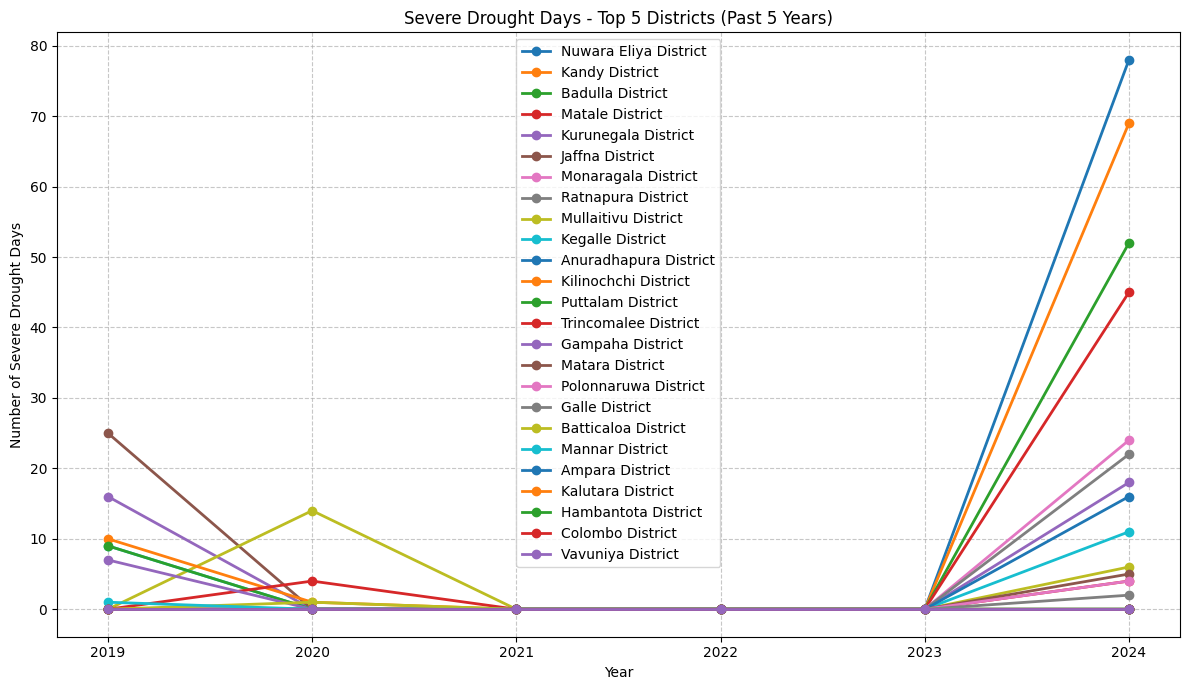

In [9]:
yearly_columns = [col for col in drought_pivot.columns if col != 'Total Drought Days']

# Plot
plt.figure(figsize=(12, 7))
for idx, row in result_table.iterrows():
    district = row['District']
    values = [row[col] for col in yearly_columns]
    plt.plot(yearly_columns, values, marker='o', linewidth=2, label=district)

plt.title('Severe Drought Days - Top 5 Districts (Past 5 Years)')
plt.xlabel('Year')
plt.ylabel('Number of Severe Drought Days')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## Map Extreme Drought Events

In [10]:
# Convert geometry field from GeoJSON to Shapely
if isinstance(gdf["geometry"].iloc[0], str):
    gdf["geometry"] = gdf["geometry"].apply(json.loads)
gdf["geometry"] = gdf["geometry"].apply(shape)

# First, let's extract unique regions with their geometries
# Group by region and take the first geometry for each region
region_geo = gdf[['hex_id', 'region', 'geometry']].drop_duplicates(subset=['hex_id'])
region_geo_gdf = gpd.GeoDataFrame(region_geo, geometry="geometry", crs="EPSG:4326")

drought_gdf = adm2_boundaries.merge(result_table, left_on='shapeName', right_on='District')

# Prepare tooltip columns
yearly_columns = [col for col in drought_gdf.columns if col.isdigit() or col == 'Total Drought Days']
tooltip_columns = ['District'] + yearly_columns

# Create the map
m = drought_gdf.explore(
    column='Total Drought Days',
    tooltip=tooltip_columns,
    cmap="OrRd",
    legend=True,
    scheme="quantiles",
    legend_kwds=dict(colorbar=True, caption=f"Total Extreme Drought Days", interval=False),
    style_kwds=dict(weight=1, fillOpacity=0.8),
    name="Drought Risk by District"
)
# Add boundaries as a separate layer for the tooltip
drought_gdf.explore(
    m=m,
    style_kwds=dict(color="black", weight=0, opacity=0.5, fillOpacity=0),
    name="District Boundaries",
    tooltip=tooltip_columns
)
m

## National Average

In [11]:
df_average = df.dropna().groupby('date')['spi'].agg(['mean']).reset_index()
df_average.head()

date      mean
0 2019-01-01 -0.370019
1 2019-02-01 -0.257167
2 2019-03-01 -0.383291
3 2019-04-01 -0.770942
4 2019-05-01 -1.237152

In [12]:
from plotnine import (
    geom_bar,
    labs,
    theme_minimal,
    element_text,
    scale_y_continuous,
    scale_x_datetime
)
from mizani.breaks import date_breaks
from mizani.formatters import date_format

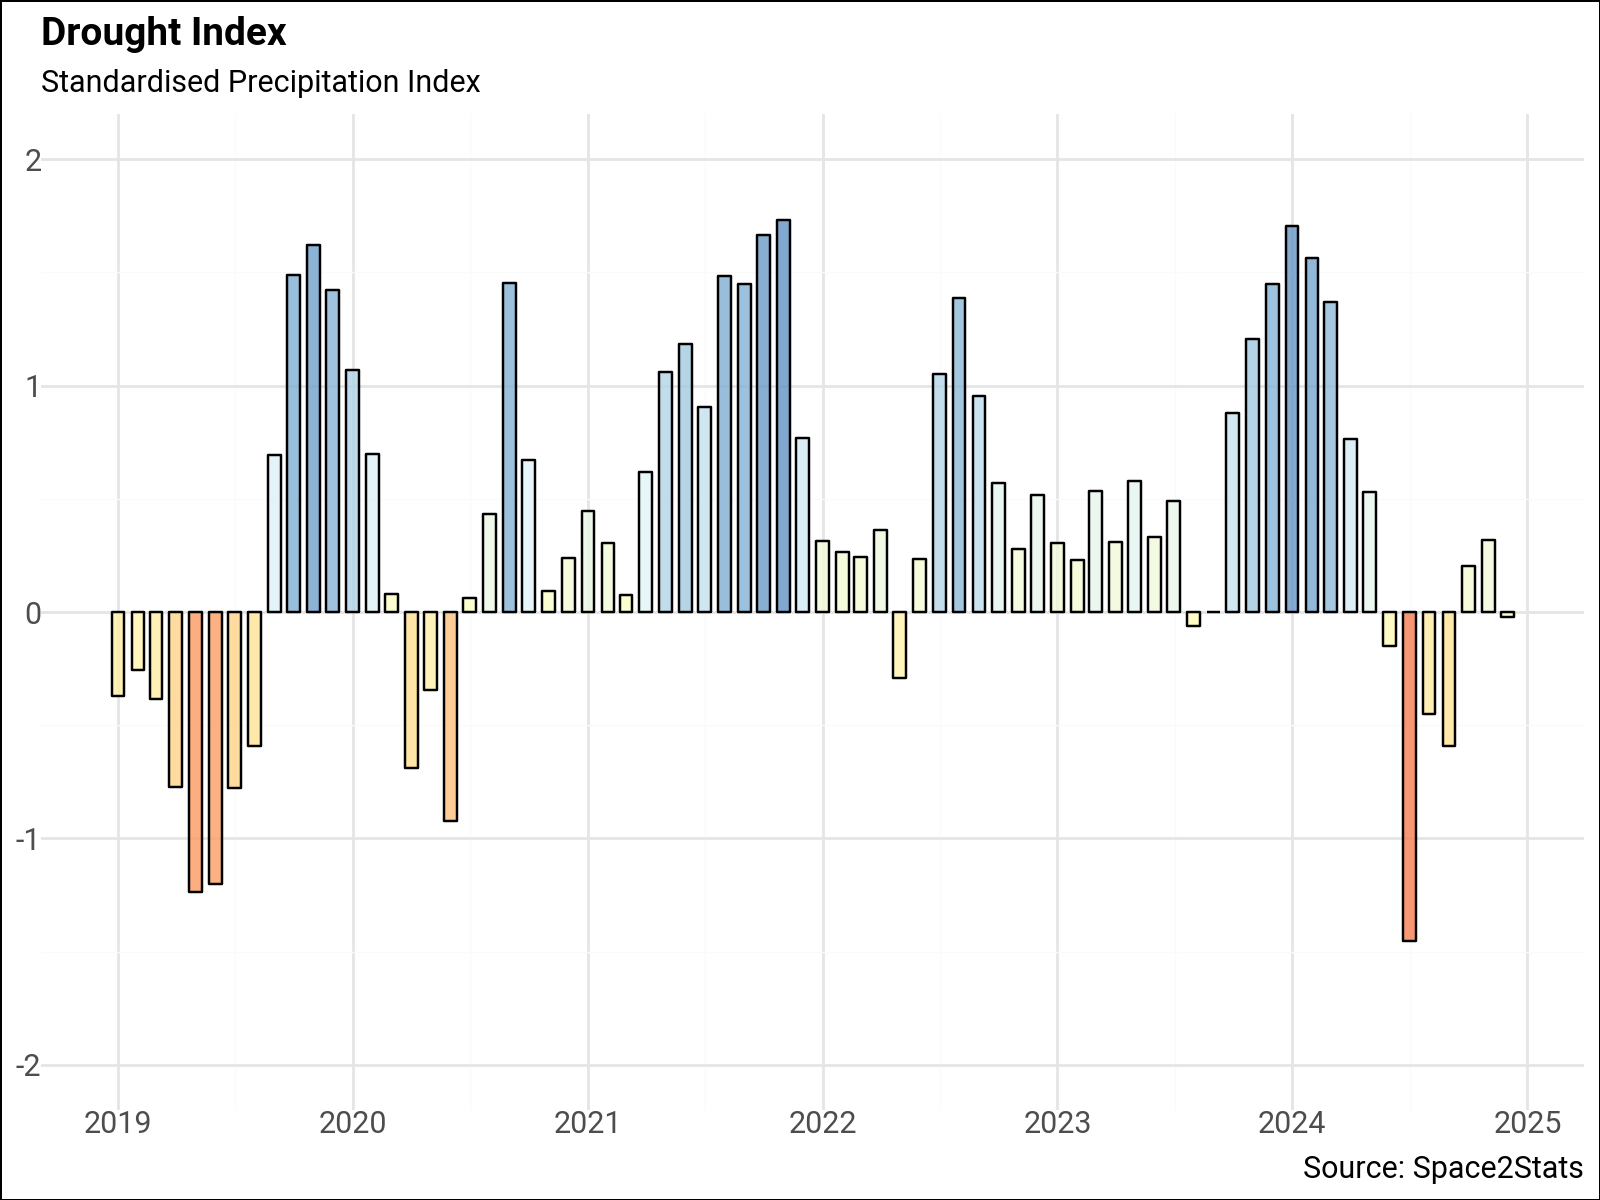

In [13]:
font = "Roboto"
p = (
    ggplot(df_average, aes(x="date", y="mean", fill="mean"))
    + geom_bar(alpha=0.8, stat="identity", color="black", width=20)
    + labs(
        x="",
        subtitle="Standardised Precipitation Index",
        title="Drought Index",
        y="",
        caption="Source: Space2Stats",
    )
    + theme_minimal()
    + theme(
        plot_background=element_rect(fill="white"),
        figure_size=(8, 6),
        text=element_text(family=font, size=11),
        plot_title=element_text(family=font, size=14, weight="bold"),
        legend_position="none",
    )
    + scale_fill_distiller(
        type="div", palette="RdYlBu", direction=1, limits=(-2, 2)
    )
    + scale_y_continuous(limits=(-2, 2))
    + scale_x_datetime(
        breaks=date_breaks(width="1 year"), labels=date_format("%Y")
    )
)
p